In [ ]:
!pip install datasets evaluate rouge_score bitsandbytes

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00


## 1. Setup and Imports

In [ ]:
# Handle warnings
import warnings
warnings.filterwarnings('ignore')

import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_kbit_training
)
from torch.optim import AdamW
from datasets import load_dataset, Dataset, DatasetDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import re
import unicodedata
from tqdm.notebook import tqdm
import random
import json
import os
from sklearn.model_selection import train_test_split

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading and Preprocessing

In [ ]:
# Load OPUS-100 dataset
dataset = load_dataset("Helsinki-NLP/opus-100", "en-vi")

README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/138k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Combine train/validation/test and use 1% sample
all_data = []
for split in ['train', 'validation', 'test']:
    all_data.extend(dataset[split])

# Take 1% of full dataset
total_samples = int(len(all_data) * 0.01)
sampled_data = all_data[:total_samples]

print(f"Total samples: {len(sampled_data)}")

Total samples: 10040


In [ ]:
# Convert to pandas DataFrame for analysis
df = pd.DataFrame([{'en': item['translation']['en'], 'vi': item['translation']['vi']}
                   for item in sampled_data])

# Add length columns
df['en_len'] = df['en'].str.len()
df['vi_len'] = df['vi'].str.len()

In [ ]:
# Check for null values
print(f"English nulls: {df['en'].isnull().sum()}")
print(f"Vietnamese nulls: {df['vi'].isnull().sum()}\n")

English nulls: 0
Vietnamese nulls: 0



In [ ]:
# Check for duplicates
print(f"Duplicate English: {df.duplicated(subset=['en']).sum()}")
print(f"Duplicate Vietnamese: {df.duplicated(subset=['vi']).sum()}")
print(f"Duplicate pairs: {df.duplicated().sum()}\n")

Duplicate English: 680
Duplicate Vietnamese: 417
Duplicate pairs: 173



In [ ]:
# Check lengths
print(f"English - Mean: {df['en_len'].mean():.1f}, Min: {df['en_len'].min()}, Max: {df['en_len'].max()}")
print(f"Vietnamese - Mean: {df['vi_len'].mean():.1f}, Min: {df['vi_len'].min()}, Max: {df['vi_len'].max()}\n")

English - Mean: 28.5, Min: 1, Max: 270
Vietnamese - Mean: 29.6, Min: 1, Max: 701



In [ ]:
# Outlier analysis
print(f"Very short English (<=5): {(df['en_len'] <= 5).sum()}")
print(f"Very long English (>=200): {(df['en_len'] >= 200).sum()}")
print(f"Very short Vietnamese (<=5): {(df['vi_len'] <= 5).sum()}")
print(f"Very long Vietnamese (>=200): {(df['vi_len'] >= 200).sum()}\n")

Very short English (<=5): 487
Very long English (>=200): 5
Very short Vietnamese (<=5): 369
Very long Vietnamese (>=200): 8



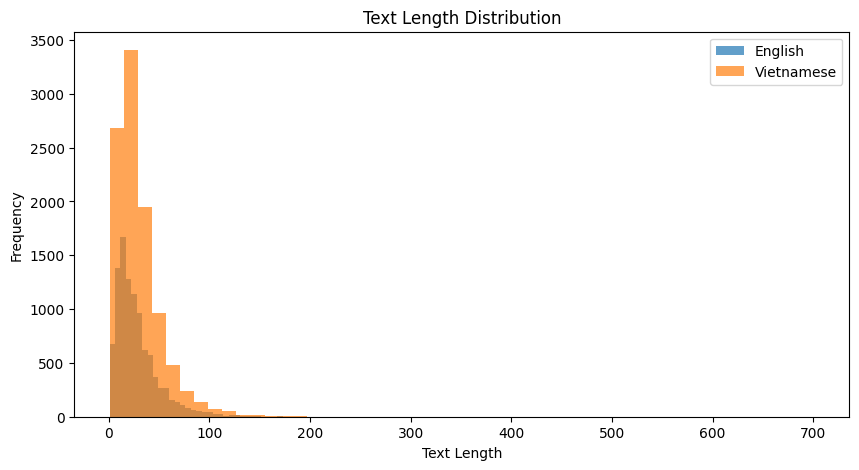

In [ ]:
# Plot length distribution
plt.figure(figsize=(10, 5))
plt.hist(df['en_len'], bins=50, alpha=0.7, label='English')
plt.hist(df['vi_len'], bins=50, alpha=0.7, label='Vietnamese')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.legend()
plt.show()

In [ ]:
# Check character sets
en_chars = set(''.join(df['en'].tolist()))
vi_chars = set(''.join(df['vi'].tolist()))

print(f"Unique English characters: {len(en_chars)}")
print(f"Unique Vietnamese characters: {len(vi_chars)}")

Unique English characters: 104
Unique Vietnamese characters: 233


In [ ]:
def preprocess_text(text, lowercase=True):
    """
    Preprocess text by normalizing whitespace, removing special characters,
    normalizing Unicode (important for Vietnamese), and optionally lowercasing.
    """
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove special characters but keep punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)

    # Normalize Unicode (important for Vietnamese)
    text = unicodedata.normalize('NFC', text)

    # Lowercase
    if lowercase:
        text = text.lower()

    return text

# Apply preprocessing
print("Preprocessing data...")
df['en_clean'] = df['en'].apply(lambda x: preprocess_text(x, lowercase=True))
df['vi_clean'] = df['vi'].apply(lambda x: preprocess_text(x, lowercase=True))

# Add cleaned text lengths
df['en_clean_len'] = df['en_clean'].str.len()
df['vi_clean_len'] = df['vi_clean'].str.len()

Preprocessing data...


In [ ]:
# Remove outliers and problematic samples
def clean_dataset(df):
    # Remove null entries
    df = df.dropna(subset=['en_clean', 'vi_clean'])

    # Remove entries with empty strings after cleaning
    df = df[(df['en_clean'].str.len() > 0) & (df['vi_clean'].str.len() > 0)]

    # Remove duplicates
    df = df.drop_duplicates(subset=['en_clean', 'vi_clean'])

    # Remove extremely long or short entries
    df = df[(df['en_clean_len'] >= 3) & (df['en_clean_len'] <= 200)]
    df = df[(df['vi_clean_len'] >= 3) & (df['vi_clean_len'] <= 200)]

    # Check for mismatched lengths (possible alignment issues)
    length_ratio = df['vi_clean_len'] / df['en_clean_len']
    df = df[(length_ratio >= 0.3) & (length_ratio <= 3.0)]

    return df

df_clean = clean_dataset(df)
print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} samples ({((len(df) - len(df_clean)) / len(df) * 100):.1f}%)")

Original dataset size: 10040
Cleaned dataset size: 9694
Removed 346 samples (3.4%)


In [ ]:
# Create training, validation, and test splits
train_df, temp_df = train_test_split(df_clean, test_size=0.2)
val_df, test_df = train_test_split(temp_df, test_size=0.5)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 7755 samples
Validation set: 969 samples
Test set: 970 samples


In [ ]:
# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[['en_clean', 'vi_clean']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['en_clean', 'vi_clean']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['en_clean', 'vi_clean']].reset_index(drop=True))

datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

## 4. Model Setup

In [ ]:
# Load EnviT5 for translation
checkpoint = "VietAI/envit5-translation"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load model with 4-bit quantization
print("Applying 4-bit quantization...")

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForSeq2SeqLM.from_pretrained(
    checkpoint,
    device_map="auto",
    quantization_config=quantization_config,
    use_cache=False
).to(device)

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# LoRA configure
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16,
    lora_alpha=32,
    target_modules="all-linear",
    lora_dropout=0.05,
    bias="none",
)

# Apply LoRA adapters to the model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.49M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Applying 4-bit quantization...


config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

trainable params: 6,782,976 || all params: 281,885,952 || trainable%: 2.4063


In [ ]:
example_sentence = "en: I thought we would go to the children's home."

inputs = tokenizer(
    example_sentence,
    return_tensors="pt",
).to(device)
generated = model.generate(**inputs, max_length=128)
print(f"EN: {example_sentence}")
print("VI:", tokenizer.decode(generated[0], skip_special_tokens=True))
print()

EN: en: I thought we would go to the children's home.
VI: vi: Tôi nghĩ chúng ta nên đến trại trẻ.



In [ ]:
# Function to preprocess data for different models
def preprocess_function(examples):
    inputs = ["en: " + ex for ex in examples["en_clean"]]
    targets = ["vi: " + ex for ex in examples["vi_clean"]]

    model_inputs = tokenizer(inputs, text_target=targets)

    return model_inputs

tokenized_datasets = datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/7755 [00:00<?, ? examples/s]

Map:   0%|          | 0/969 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [ ]:
# Compute BLEU and ROUGE metrics for evaluation
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 with pad token id
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode predictions and references
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # wrap each label in its own list:
    references = [[lab] for lab in decoded_labels]

    # Compute all metrics
    bleu_score = bleu.compute(predictions=decoded_preds, references=references)
    rouge_scores = rouge.compute(predictions=decoded_preds, references=references)

    results = {
        "bleu": bleu_score["bleu"],
        "rouge1": rouge_scores["rouge1"],
        "rouge2": rouge_scores["rouge2"],
        "rougeL": rouge_scores["rougeL"],
    }

    return results

In [ ]:
# Configure training arguments
model_name = checkpoint.split('/')[-1]
result_path = "./finetuned_model/" + model_name

# Training parameters
num_epochs = 3
train_batch_size = 8
eval_batch_size = 8
lr = 5e-5
ga = 4

# Calculate num_training_steps
train_size = len(tokenized_datasets["train"])
batches_per_epoch = math.ceil(train_size / (train_batch_size * ga))
num_training_steps = batches_per_epoch * num_epochs

# Set eval_steps to 10% of num_training_steps
eval_steps = max(1, num_training_steps // 10)

training_args = Seq2SeqTrainingArguments(
    output_dir=result_path,
    report_to="none",
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=eval_steps,
    save_steps=eval_steps,
    logging_steps=eval_steps,
    learning_rate=lr,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    gradient_accumulation_steps=ga,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    warmup_ratio=0.1,
    save_total_limit=3,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    label_names=["labels"]
)

# Initialize data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    padding="longest",
    pad_to_multiple_of=8,
    return_tensors="pt"
)

In [ ]:
# Set up the Trainer with early stopping
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
print("▶️ Evaluating pretrained model…")
metrics_pretrained = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("Pretrained metrics:", metrics_pretrained)

▶️ Evaluating pretrained model…


Pretrained metrics: {'eval_loss': 1.623188853263855, 'eval_model_preparation_time': 0.0148, 'eval_bleu': 0.22322671701738633, 'eval_rouge1': 0.6532072867974541, 'eval_rouge2': 0.42550470961651515, 'eval_rougeL': 0.6233171685865274, 'eval_runtime': 199.7273, 'eval_samples_per_second': 4.857, 'eval_steps_per_second': 0.611}


In [ ]:
print("▶️ Starting fine-tuning…")
trainer.train()

▶️ Starting fine-tuning…


Step,Training Loss,Validation Loss,Model Preparation Time,Bleu,Rouge1,Rouge2,Rougel
72,1.645400,1.393898,0.014800,0.303705,0.659673,0.436508,0.631062
144,1.450000,1.320073,0.014800,0.320178,0.666835,0.443473,0.636863
216,1.458500,1.302211,0.014800,0.321923,0.667453,0.446366,0.637784
288,1.453700,1.294573,0.014800,0.325266,0.669868,0.447965,0.640308
360,1.404800,1.288604,0.014800,0.330640,0.671603,0.452720,0.643070
432,1.431000,1.284682,0.014800,0.331235,0.670939,0.449474,0.641717
504,1.381900,1.281274,0.014800,0.333806,0.671003,0.451804,0.642814
576,1.385300,1.280219,0.014800,0.333407,0.671115,0.451909,0.642673
648,1.371700,1.279799,0.014800,0.333298,0.671185,0.451550,0.642959
720,1.388400,1.279528,0.014800,0.333069,0.669980,0.449565,0.641704


TrainOutput(global_step=720, training_loss=1.4370699776543512, metrics={'train_runtime': 3553.8635, 'train_samples_per_second': 6.546, 'train_steps_per_second': 0.204, 'total_flos': 749848091811840.0, 'train_loss': 1.4370699776543512, 'epoch': 2.9649484536082475})

In [ ]:
print("▶️ Evaluating fine-tuned model…")
metrics_finetuned = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("Fine-tuned metrics:", metrics_finetuned)

▶️ Evaluating fine-tuned model…


Fine-tuned metrics: {'eval_loss': 1.307726263999939, 'eval_model_preparation_time': 0.0148, 'eval_bleu': 0.32221887910593794, 'eval_rouge1': 0.6681939749828427, 'eval_rouge2': 0.4413803733021008, 'eval_rougeL': 0.6379258923609592, 'eval_runtime': 189.6847, 'eval_samples_per_second': 5.114, 'eval_steps_per_second': 0.643, 'epoch': 2.9649484536082475}


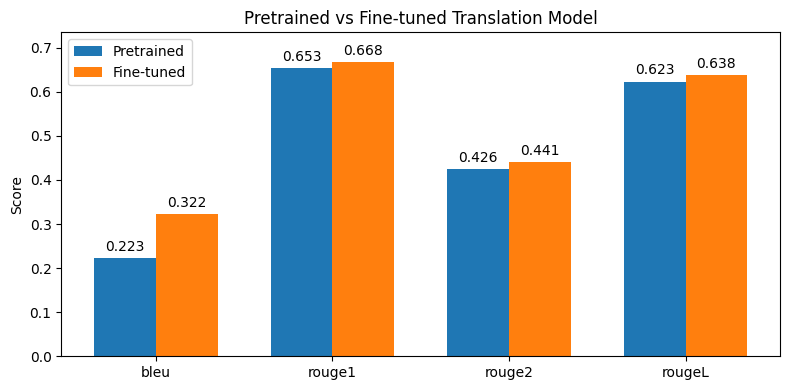

In [ ]:
metrics_to_plot = ["eval_bleu", "eval_rouge1", "eval_rouge2", "eval_rougeL"]
labels   = [m.replace("eval_", "") for m in metrics_to_plot]
pre_vals = [metrics_pretrained[m] for m in metrics_to_plot]
fine_vals= [metrics_finetuned[m]  for m in metrics_to_plot]

# ───── Plot setup ─────
x     = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))

bars_pre   = ax.bar(x - width/2, pre_vals,  width, label="Pretrained")
bars_finet = ax.bar(x + width/2, fine_vals, width, label="Fine-tuned")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Score")
ax.set_title("Pretrained vs Fine-tuned Translation Model")
ax.legend()

# ───── Annotate bars ─────
ax.bar_label(bars_pre,   padding=3, fmt='%.3f')
ax.bar_label(bars_finet, padding=3, fmt='%.3f')

# ───── Add head‐room ─────
ax.margins(y=0.1)

plt.tight_layout()
plt.show()